In [1]:
import ujson as json
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import sklearn.cluster as clstr
import scipy.sparse as sp
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
import seaborn as sb
import pandas as pd
import itertools

In [17]:
positions = []
grottoes = []
files = []
ARTIC_NAMES = {'foot 1': 0,
               'foot 2': 1,
               'knee 1': 2,
               'knee 2': 3,
               'belly': 4,
               'elbow 1': 5,
               'elbow 2': 6,
               'hand 1': 7,
               'hand 2': 8,
               'eye 1': 9,
               'eye 2': 10,
               'shoulder 1': 11,
               'shoulder 2': 12}

with open('2_test_2.json', 'r') as f:
    data3 = json.load(f)
    
    for apsara in data3['apsaras']:
        grottoes.append(apsara['grottoe'])
        files.append(apsara['file'])
        access = apsara['positions']
        position = []
        for articulation in ARTIC_NAMES.keys():
            position.append(access[articulation])
        positions.append(position)
positions = np.array(positions)

In [18]:
positions.shape

(84, 13, 2)

In [19]:
def plot_line(apsara, a1, a2, ax, c='r'):
    """
    Plot the leg/arm/... between articulations a1 and a2
    """
    i1 = ARTIC_NAMES[a1]
    i2 = ARTIC_NAMES[a2]
    ax.plot(apsara[(i1, i2), 0], apsara[(i1, i2), 1], c)
def plot_pose(apsara, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    plt.gca().invert_yaxis()
    plot_line(apsara, 'foot 1', 'knee 1', ax)
    plot_line(apsara, 'knee 1', 'belly', ax)
    plot_line(apsara, 'foot 2', 'knee 2', ax)
    plot_line(apsara, 'knee 2', 'belly', ax)
    plot_line(apsara, 'shoulder 1', 'belly', ax)
    plot_line(apsara, 'shoulder 2', 'belly', ax)
    plot_line(apsara, 'shoulder 1', 'elbow 1', ax)
    plot_line(apsara, 'shoulder 2', 'elbow 2', ax)
    plot_line(apsara, 'elbow 1', 'hand 1', ax)
    plot_line(apsara, 'elbow 2', 'hand 2', ax)
    plot_line(apsara, 'shoulder 1', 'shoulder 2', ax)
    plot_line(apsara, 'eye 1', 'eye 2', ax)

def plot_all(apsaras, line_length=12):
    fig, ax = plt.subplots()
    for i, apsara in enumerate(apsaras):
        plot_pose(apsara + 5*np.array([[i%line_length, i//line_length]]), ax=ax)

In [20]:
def preprocess(data):    
    data = 1.*np.delete(data, np.all(np.all(data==-1, axis=1), axis=1), axis=0)
    data[data==-1] = np.nan
    norm_data = (data - np.nanmean(data, axis=1)[:, None, :]) / np.nanstd(data, axis=1, ddof=1)[:, None, :]
    return -norm_data

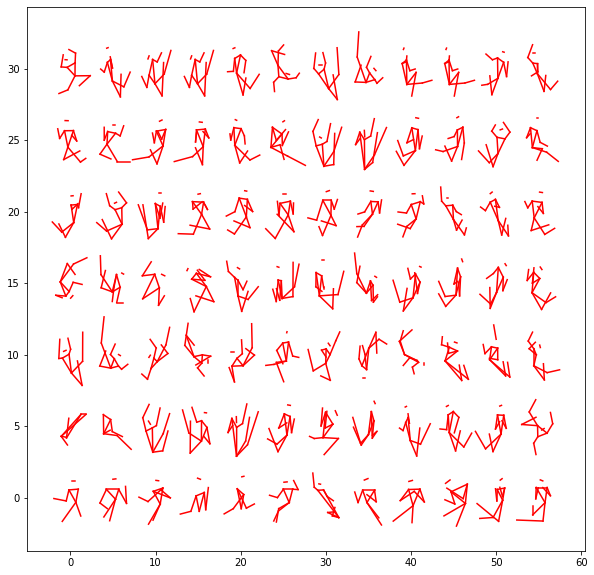

In [21]:
plot_all(preprocess(positions))

## Kmeans on the raw poses

In [22]:
def remove_nans(data):
    return np.delete(data, 
                     np.any(np.any(np.isnan(data),
                                   axis=1),
                            axis=1),
                     axis=0)
def prepare_kmeans(data, n_clusters):
    data = remove_nans(preprocess(data))
    flat_data = data.reshape(data.shape[0], -1)
    kmeans = clstr.KMeans(n_clusters=n_clusters).fit(flat_data)
    return kmeans

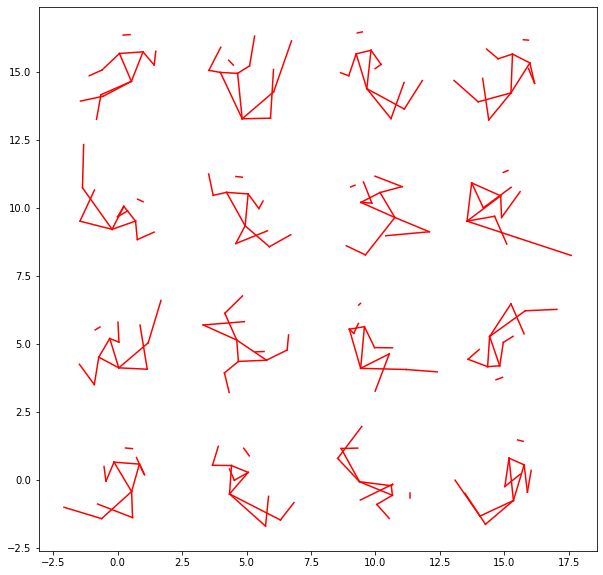

In [23]:
km = prepare_kmeans(positions, 16)
centers = km.cluster_centers_
plot_all(centers.reshape(centers.shape[0], -1, 2), line_length=4)

## Kmeans on the angles

In [17]:
def make_vec(keypoints, pt1, pt2):
    """
    returns vector pt1->pt2
    """
    slicer = np.zeros(13)
    slicer[ARTIC_NAMES[pt1]] = -1
    slicer[ARTIC_NAMES[pt2]] = 1
    # i: articulation
    # j: apsara n°
    # k: 2D pt coordinate
    return np.einsum("i,jik->jk", slicer, keypoints)

In [30]:
def angle(vec1, vec2):
    """
    Compute angle between vectors 1 and 2
    vec1 and vec2 are lists of vectors (in np format)
    """
    prod = np.einsum("ij,ij->i", vec1, vec2)
    nrm = np.linalg.norm(vec1, axis=1)\
        * np.linalg.norm(vec2, axis=1)
    return np.arccos(prod / nrm)

def get_angles(keypoints):
    angle_knee1 = angle(make_vec(keypoints, "knee 1", "foot 1"),
                        make_vec(keypoints, "knee 1", "belly"))
    angle_knee2 = angle(make_vec(keypoints, "knee 2", "foot 2"),
                        make_vec(keypoints, "knee 2", "belly"))
    angle_elbow1 = angle(make_vec(keypoints, "elbow 1", "hand 1"),
                         make_vec(keypoints, "elbow 1", "shoulder 1"))
    angle_elbow2 = angle(make_vec(keypoints, "elbow 2", "hand 2"),
                         make_vec(keypoints, "elbow 2", "shoulder 2"))
    return np.stack([angle_knee1,
                     angle_knee2,
                     angle_elbow1,
                     angle_elbow2], axis=1)

In [118]:
agls = get_angles(remove_nans(preprocess(positions)))

In [119]:
N_CLUSTER = 16
kma = clstr.KMeans(n_clusters=N_CLUSTER,
                   max_iter=10000,
                   tol=1e-9
                  ).fit(agls)
centers = kma.cluster_centers_

In [121]:
agls_frame = pd.DataFrame(agls, columns=['knee 1',
                                   'knee 2',
                                   'elbow 1',
                                   'elbow 2'])
centers_frame = pd.DataFrame(centers, columns=['knee 1',
                                      'knee 2',
                                      'elbow 1',
                                      'elbow 2'])
results_frame = pd.concat([agls_frame,
                           centers_frame],
                          keys=['raw angles',
                                'kmeans centers'],
                          names=['origin', 'number'])
results_frame.reset_index(inplace=True)
results_frame.drop(columns=['number'], inplace=True)

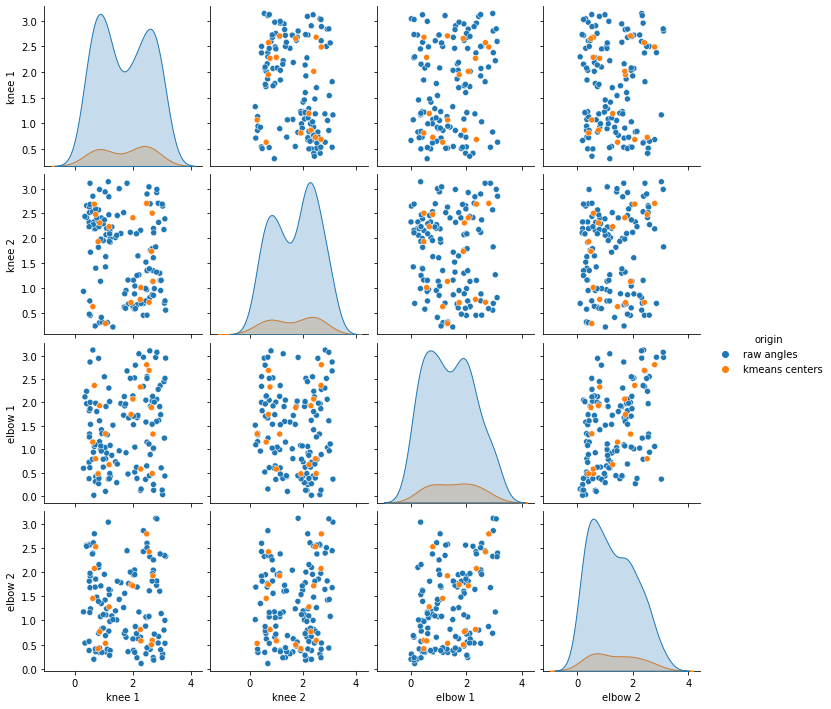

In [122]:
sb.pairplot(results_frame, hue='origin')

## DBSCAN

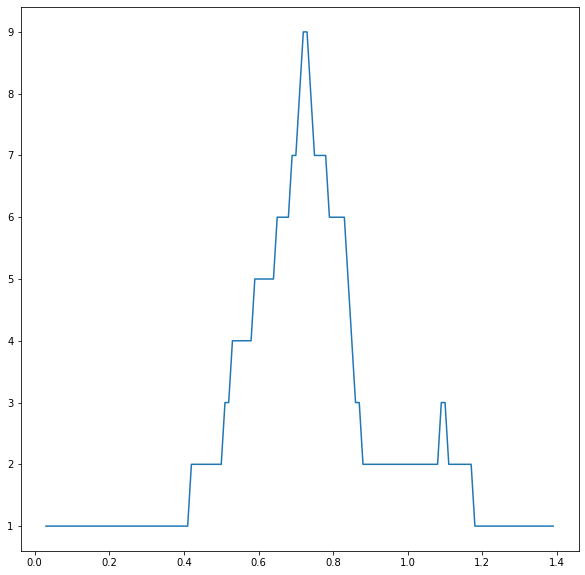

In [181]:
EPS = .01*np.arange(3, 140)
N = []
for eps in EPS:
    N.append(len(set(clstr.DBSCAN(eps=eps).fit(agls).labels_)))

plt.plot(EPS, N)

In [164]:
db = clstr.DBSCAN(eps=0.8).fit(agls)

In [165]:
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [166]:
# Pick the "core samples" and color them
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

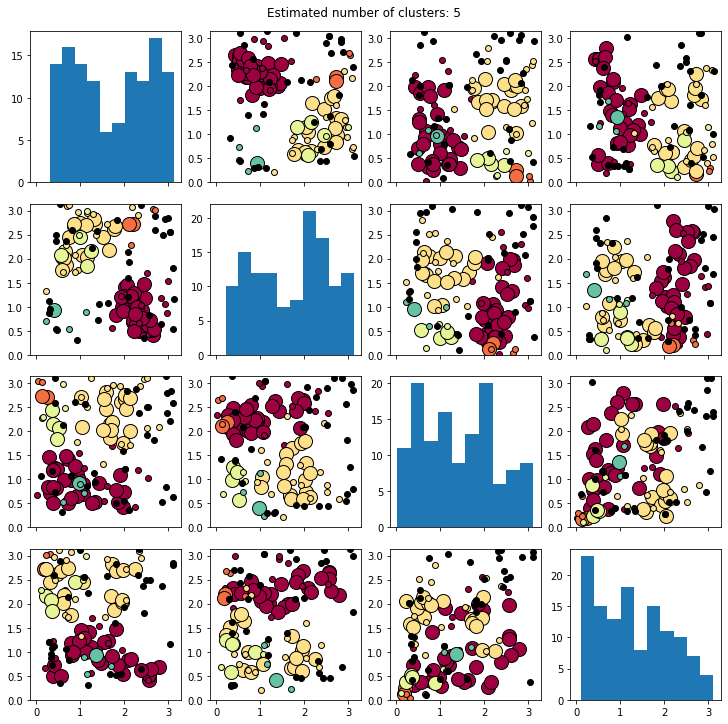

In [186]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig, axs = plt.subplots(4, 4, subplot_kw=dict(box_aspect=1),
                         sharex=True, constrained_layout=True)
for i, j in itertools.product(range(4), range(4)):
    ax = axs[i, j]
    if i==j:
        ax.hist(agls[:, i])
        continue
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = agls[class_member_mask & core_samples_mask]
        ax.plot(
            xy[:, i],
            xy[:, j],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = agls[class_member_mask & ~core_samples_mask]
        ax.plot(
            xy[:, i],
            xy[:, j],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )
        ax.set_ylim([0., np.pi])

fig.suptitle("Estimated number of clusters: %d" % n_clusters_)
plt.show()